In [1]:
from scipy.interpolate import CubicSpline, CubicHermiteSpline
import argparse
import airsimneurips as airsim
import cvxpy as cp
import numpy as np
import time
import airsimneurips as airsim
import gtp
import baseline_racer
import baseline_racer_gtp
import hum_drum_racer
%matplotlib inline
import matplotlib.pyplot as plt

Loading Julia...



In [2]:
import track_defs
gate_pose_dicts = track_defs.soccer_medium_gate_pose_dicts

In [3]:
gate_inner_dims_dict= {   'x_val': 1.6,
    'y_val': 0.2,
    'z_val': 1.6}
gate_outer_dims_dict= {   'x_val': 2.1333333333333333,
    'y_val': 0.2,
    'z_val': 2.1333333333333333}

In [23]:
# airsim.Quaternionr(x_val,y_val,z_val,w_val) # quaternion ordering
gate_poses = [
    airsim.Pose(
        airsim.Vector3r(
            d['position']['x_val'],
            d['position']['y_val'],
            d['position']['z_val']
#             d['position']['y_val'],
#             d['position']['z_val'],
#             d['position']['x_val']
        ),
        airsim.Quaternionr(
            d['orientation']['x_val'],
            d['orientation']['y_val'],
            d['orientation']['z_val'],
            d['orientation']['w_val']
        )
    ) for d in gate_pose_dicts
]
# gate_directions = [gtp.rotate_vector(g.orientation, airsim.Vector3r(1,0,0)) for g in gate_poses]
gate_directions = [gtp.rotate_vector(g.orientation, airsim.Vector3r(0,1,0)) for g in gate_poses]
# try rearranging the dimensions here:
gate_inner_dims = airsim.Vector3r(
    gate_inner_dims_dict['x_val'],
    gate_inner_dims_dict['y_val'],
    gate_inner_dims_dict['z_val'],
#     gate_inner_dims_dict['y_val'],
#     gate_inner_dims_dict['x_val'],
#     gate_inner_dims_dict['z_val'],
)
gate_outer_dims = airsim.Vector3r(
    gate_outer_dims_dict['x_val'],
    gate_outer_dims_dict['y_val'],
    gate_outer_dims_dict['z_val'],
#     gate_outer_dims_dict['y_val'],
#     gate_outer_dims_dict['x_val'],
#     gate_outer_dims_dict['z_val'],
)

drone_names = ["drone_1", "drone_2"]
drone_params = [
    {"r_safe": 0.4,
     "r_coll": 0.3,
     "v_max": 20.0,
     "a_max": 15.0},
    {"r_safe": 0.4,
     "r_coll": 0.3,
     "v_max": 20.0,
     "a_max": 15.0}]
parser = argparse.ArgumentParser(description='')
parser.add_argument('--dt', type=float, default=0.05)
parser.add_argument('--dt_min', type=float, default=0.05)
parser.add_argument('--r_safe', type=float, default=0.0)
parser.add_argument('--v_max', type=float, default=80.0)
parser.add_argument('--a_max', type=float, default=40.0)
parser.add_argument('--n', type=int, default=14)
parser.add_argument('--blocking_behavior', dest='blocking', action='store_true', default=False)
parser.add_argument('--vel_constraints', dest='vel_constraints', action='store_true', default=False)
parser.add_argument('--horizon', type=int, default=10)
parser.add_argument('--no_resample', dest='resample', action='store_false', default=True)
parser.add_argument('--replan_from_lookahead', dest='replan_from_lookahead', action='store_true', default=False)
parser.add_argument('--plot_gtp', dest='plot_gtp', action='store_true', default=False)
parser.add_argument('--level_name', type=str, choices=["Soccer_Field_Easy", "Soccer_Field_Medium", "ZhangJiaJie_Medium", "Building99_Hard", 
    "Qualifier_Tier_1", "Qualifier_Tier_2", "Qualifier_Tier_3"], default="ZhangJiaJie_Medium")
parser.add_argument('--enable_viz_traj', dest='viz_traj', action='store_true', default=False)
parser.add_argument('--race_tier', type=int, choices=[1,2,3], default=1)
traj_params = parser.parse_known_args()[0]

start_state = airsim.MultirotorState()
start_state.kinematics_estimated.position = airsim.Vector3r(6.373129367828369, 81.43741607666016, -42.88162612915039)

In [24]:
start_state.kinematics_estimated.position.z_val += 3
start_state.kinematics_estimated.position

<Vector3r> {   'x_val': 6.373129367828369,
    'y_val': 81.43741607666016,
    'z_val': -39.88162612915039}

In [25]:
controller = gtp.IBRController(traj_params,drone_params,gate_poses)

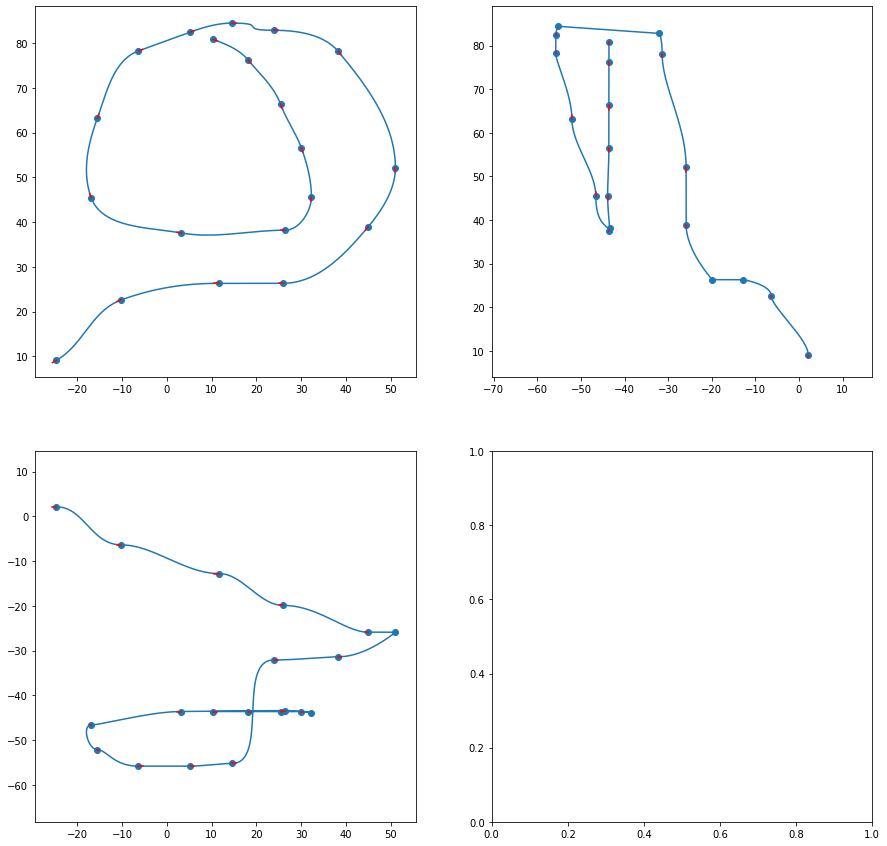

In [26]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0,0].plot([c[0] for c in controller.track.track_centers],[c[1] for c in controller.track.track_centers])
axs[0,0].scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[0,0].plot([g.position.x_val, g.position.x_val+d.x_val],[g.position.y_val, g.position.y_val+d.y_val],c="red")
axs[0,0].axis('equal')

axs[1,0].plot([c[0] for c in controller.track.track_centers],[c[2] for c in controller.track.track_centers])
axs[1,0].scatter([g.position.x_val for g in gate_poses],[g.position.z_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[1,0].plot([g.position.x_val, g.position.x_val+d.x_val],[g.position.z_val, g.position.z_val+d.z_val],c="red")
axs[1,0].axis('equal')

axs[0,1].plot([c[2] for c in controller.track.track_centers],[c[1] for c in controller.track.track_centers])
axs[0,1].scatter([g.position.z_val for g in gate_poses],[g.position.y_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[0,1].plot([g.position.z_val, g.position.z_val+d.z_val],[g.position.y_val, g.position.y_val+d.y_val],c="red")
axs[0,1].axis('equal')
axs[0,1].set_ylim(ymin=4,ymax=89)
# axs[0,1].set_ylim(ymin=axs[0,0].get_ylim()[0],ymax=axs[0,0].get_ylim()[1])
plt.show()

# visualize GTP trajectories

In [28]:
# start_pos = start_state.kinematics_estimated.position
# p0 = [start_pos.x_val, start_pos.y_val, start_pos.z_val]
# joint_p0 = np.concatenate([p0-np.array([[2,0,0]]),p0+np.array([[2,0,0]])])
# # ego_id = 1; opp_id = 0;
# ego_id = 0; opp_id = 1;
# base_traj = controller.init_trajectory(ego_id,joint_p0[ego_id,:])
# # ego_traj = controller.iterative_br(ego_id,joint_p0,n_game_iterations=5)
# # opp_traj = controller.iterative_br(opp_id,joint_p0,n_game_iterations=5)
# # # ego_traj = controller.best_response(ego_id,joint_p0,[ego_traj,opp_traj])

In [29]:
# base_traj[1,:]

array([  6.25251315,  80.75337178, -43.57999802])

In [31]:
# plt.figure(figsize=(12,8))
# plt.scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
# plt.scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
#             [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])
# plt.plot(base_traj[:,0],base_traj[:,1],"black")
# # plt.plot(opp_traj[:,0],opp_traj[:,1],"red")
# # plt.plot(ego_traj[:,0],ego_traj[:,1],"green")
# plt.axis('equal')
# plt.show()

# visualize global trajectories

In [32]:
optimizer = hum_drum_racer.GlobalTrajectoryOptimizer(traj_params,drone_params[1],gate_poses,gate_inner_dims,gate_outer_dims)

In [33]:
# pos = optimizer.compute_global_optimal_trajectory(start_state,
#     resample=True,
#     n = 5,
#     dt_min = 0.05)
optimizer.traj_params.r_safe = 0.0
optimizer.traj_params.dt = 0.2
traj = optimizer.compute_global_optimal_trajectory(start_state)
pos = traj.pos
vel = traj.vel
accel = traj.accel
t_vec = traj.t_vec

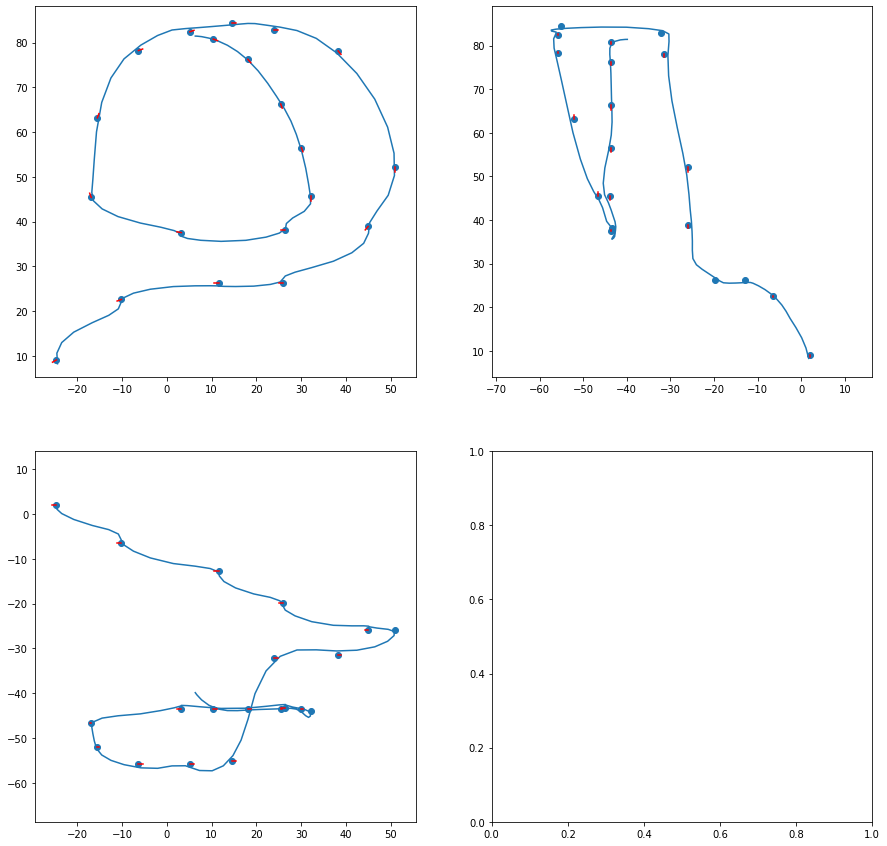

In [34]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0,0].plot([p[0] for p in pos],[p[1] for p in pos])
axs[0,0].scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[0,0].plot([g.position.x_val, g.position.x_val+d.x_val],[g.position.y_val, g.position.y_val+d.y_val],c="red")
axs[0,0].axis('equal')

axs[1,0].plot([p[0] for p in pos],[p[2] for p in pos])
axs[1,0].scatter([g.position.x_val for g in gate_poses],[g.position.z_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[1,0].plot([g.position.x_val, g.position.x_val+d.x_val],[g.position.z_val, g.position.z_val+d.z_val],c="red")
axs[1,0].axis('equal')

axs[0,1].plot([p[2] for p in pos],[p[1] for p in pos])
axs[0,1].scatter([g.position.z_val for g in gate_poses],[g.position.y_val for g in gate_poses])
for (g,d) in zip(gate_poses,gate_directions):
    axs[0,1].plot([g.position.z_val, g.position.z_val+d.z_val],[g.position.y_val, g.position.y_val+d.y_val],c="red")
axs[0,1].axis('equal')
axs[0,1].set_ylim(ymin=4,ymax=89)
# axs[0,1].set_ylim(ymin=axs[0,0].get_ylim()[0],ymax=axs[0,0].get_ylim()[1])
plt.show()

In [ ]:
# pos,vel,accel,t_vec = optimizer.compute_global_optimal_trajectory(start_state,
#     n = 5,
#     dt_min = 0.05)

In [ ]:
# p0 = traj.pos[15,:] + [0.0,0.0,1.0]
# step = truncate_traj(p0,traj.pos,step=step)
# step

In [ ]:
# def truncate_traj(pos,traj,truncate_distance=0.05,step=1,horizon=10):
#     p1 = traj[step,:]
#     for k in range(step,traj.shape[0]-horizon):
#         p2 = traj[k+1,:]
#         dp = (p1-p2) / np.linalg.norm(p1-p2)
#         if dp.dot(pos-p2) > truncate_distance:
#             return k
#     return step

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter([p[0] for p in pos],[p[1] for p in pos],marker="x")
plt.plot([p[0] for p in pos],[p[1] for p in pos])
plt.scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
plt.scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])
plt.scatter([p0[0]],[p0[1]],c="cyan")
# plt.scatter([pos[k_truncate,0]],[pos[k_truncate,1]],c="red")
# plt.plot(ego_traj[:,0],ego_traj[:,1],"red")
plt.axis('equal')
plt.show()

In [ ]:
# s_ego = np.cumsum(np.sqrt(np.sum(np.square(np.diff(ego_traj,axis=0)),axis=1)))
# t_ego = np.cumsum([controller.dt for s in s_ego])

In [ ]:
s_global = np.cumsum([np.linalg.norm(v)*d for (v,d) in zip(vel,np.diff(t_vec))])
t_global = t_vec[0:-1]
plt.plot(t_global,s_global)
# plt.plot(t_ego,s_ego)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
axs[0].plot(t_vec,vel)
axs[0].plot(t_vec,[np.linalg.norm(v) for v in vel])
axs[1].plot(t_vec,accel)
plt.show()

In [ ]:
np.cumsum(np.concatenate([[0.0], [0.1,0.1,0.1]]))

In [ ]:
np.arange(0.0,1.0,0.1)